In [1]:
import rasterio as rio
import geopandas as gpd
import pandas as pd

In [2]:
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

In [3]:
import os
import numpy as np

In [4]:
base=os.path.join(os.getcwd(),'..')

In [5]:
area=os.path.join(base,'data','data_IEM','SPAM_2005_v3.2','SPAM2005V3r2_global_H_TA_WHEA_A.tif')
yld=os.path.join(base,'data','data_IEM','SPAM_2005_v3.2','SPAM2005V3r2_global_Y_TA_WHEA_A.tif')

In [6]:
gaul=gpd.read_file(os.path.join(base,'data','data_IEM','GAUL','g2015_2005_2.shp'))

In [7]:
def plotData(fn):
    import rasterio.plot as roip
    img = rio.open(fn)
    data = img.read(1)
    fig, ax = plt.subplots(figsize=(20,7))
    image_hidden = ax.imshow(img.read()[0])
    fig.colorbar(image_hidden, ax=ax)
    roip.show(img, ax=ax)
    fn=os.path.join(base,'Nitrogen_plot.pdf')
    plt.savefig(fn, format="pdf", bbox_inches="tight",dpi=1000)

In [8]:
def setNaN(data):
    x=data.min()
    data[data==x] = np.nan
    return data

In [9]:
def readImage(fn):
    ras = rio.open(fn)
    return setNaN(ras.read(1))

In [10]:
def imageWrite(data,filename):
    im3=rio.open(area)
    kwargs = im3.meta
    kwargs.update(
        dtype=rio.float32,
        count=1,
        compress='lzw')

    with rio.open(os.path.join(base, filename), 'w', **kwargs) as dst:
        dst.write_band(1, data.astype(rio.float32))
    return os.path.join(base, filename)

In [11]:
area_data=readImage(area)
yield_data=readImage(yld)

In [12]:
# production data (Question 1)

production_data=np.multiply(area_data,yield_data)/1000000000
prod_file = imageWrite(production_data,'Production.tif')

In [13]:
## N-output (Question 3)

n_output= production_data*0.02
n_file = imageWrite(n_output,'N_output1.tif')

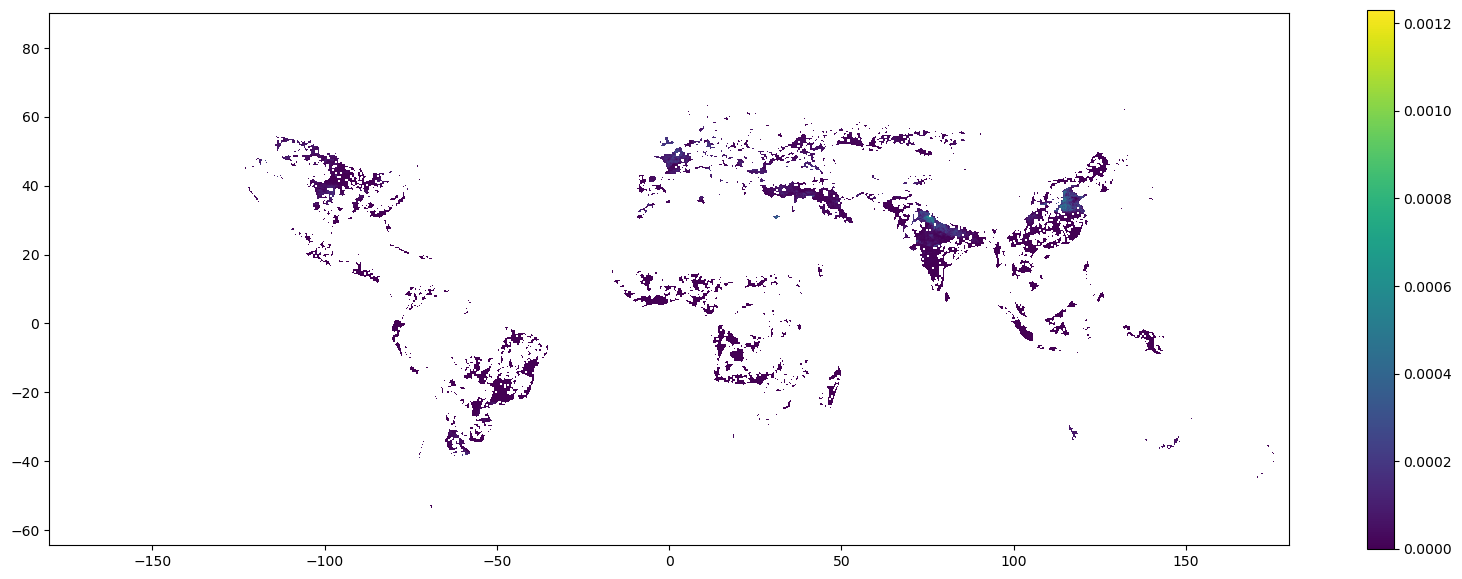

In [14]:
## N-output plot (Question 3)

plotData(n_file)

In [15]:
### country wise production (Question 2)

zonal_production = zonal_stats(gaul, prod_file, stats="sum")
gaul_prod=pd.concat([gaul,pd.DataFrame(zonal_production)],axis=1)
gaul_prod=gaul_prod.rename(columns={'sum':'Production(MT)'})
country_level_agg_production = gaul_prod.groupby('ADM0_CODE').sum()
gaul_country=gaul_prod[['ADM0_CODE', 'ADM0_NAME']].drop_duplicates(subset=['ADM0_CODE'])
country_level_agg_production=pd.merge(country_level_agg_production,gaul_country,on='ADM0_CODE',how='left')
country_level_agg_production_req=country_level_agg_production.drop(columns=['ADM2_CODE', 'STR2_YEAR', 'EXP2_YEAR', 'ADM1_CODE','Shape_Leng', 'Shape_Area',])
country_level_agg_production_req.to_csv(os.path.join(base,'Counrty level production.csv'))

C:\Users\pushkargaur\AppData\Local\Temp\ipykernel_20796\1735978270.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_level_agg_production = gaul_prod.groupby('ADM0_CODE').sum()


In [16]:
#### 10 biggest wheat producers the country-level values of N output (Question 4 a)

zonal_noutput = zonal_stats(gaul, n_file, stats="sum")
gaul_noutput=pd.concat([gaul_prod,pd.DataFrame(zonal_noutput)],axis=1)
gaul_noutput=gaul_noutput.rename(columns={'sum':'N output'})
country_level_agg_noutput = gaul_noutput.groupby('ADM0_CODE').sum()
gaul_country=gaul_noutput[['ADM0_CODE', 'ADM0_NAME']].drop_duplicates(subset=['ADM0_CODE'])
country_level_agg_noutput=pd.merge(country_level_agg_noutput,gaul_country,on='ADM0_CODE',how='left')

C:\Users\pushkargaur\AppData\Local\Temp\ipykernel_20796\3023085207.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_level_agg_noutput = gaul_noutput.groupby('ADM0_CODE').sum()


In [17]:
country_level_agg_noutput_req=country_level_agg_noutput.sort_values(by='N output',ascending=False).iloc[0:10,:]
country_level_agg_noutput_req=country_level_agg_noutput_req.rename(columns={'ADM0_NAME':'Country'})

In [18]:
nue=pd.read_csv(os.path.join(base,'data','data_IEM','NUE_Zhang_et_al_2015','Country_NUE_assumption.csv'))
nue['Country']=nue['Country'].replace('USA','United States of America')
nue['Country']=nue['Country'].replace('RussianFed','Russian Federation')

In [19]:
df_nue=pd.merge(country_level_agg_noutput_req,nue,on='Country')

In [20]:
df_nue.columns

Index(['ADM0_CODE', 'ADM2_CODE', 'STR2_YEAR', 'EXP2_YEAR', 'ADM1_CODE',
       'Shape_Leng', 'Shape_Area', 'Production(MT)', 'N output', 'Country',
       'NUE'],
      dtype='object')

In [21]:
df_nue_req = df_nue[['ADM0_CODE', 'N output', 'Country','NUE', 'Production(MT)']]

In [22]:
df_nue_req['N input'] = df_nue_req['N output']/df_nue_req['NUE']
df_nue_req['N loss'] = abs(df_nue_req['N input']-df_nue_req['N output'])

C:\Users\pushkargaur\AppData\Local\Temp\ipykernel_20796\1598696483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nue_req['N input'] = df_nue_req['N output']/df_nue_req['NUE']
C:\Users\pushkargaur\AppData\Local\Temp\ipykernel_20796\1598696483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nue_req['N loss'] = abs(df_nue_req['N input']-df_nue_req['N output'])


In [24]:
df_nue_req.to_csv(os.path.join(base,'N_output_4a.csv'))

In [25]:
import seaborn as sns

In [26]:
df_nue_req.columns

Index(['ADM0_CODE', 'N output', 'Country', 'NUE', 'Production(MT)', 'N input',
       'N loss'],
      dtype='object')

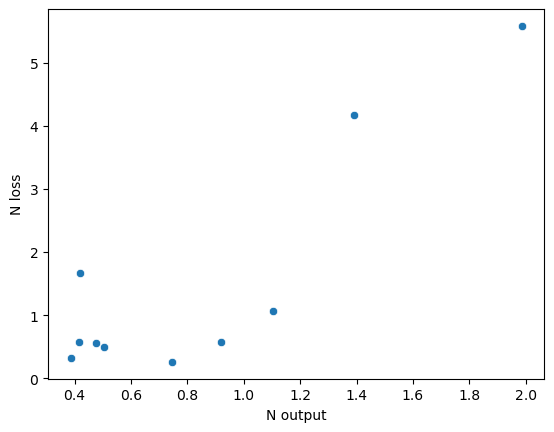

In [27]:
sns.scatterplot(data=df_nue_req,x='N output',y='N loss')
fn=os.path.join(base,'Rel_btw_No_Nl.pdf')
plt.savefig(fn, format="pdf", bbox_inches="tight",dpi=300)